In [53]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from unidecode import unidecode
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate,cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import joblib
from skimpy import skim

In [54]:
sub = pd.read_csv("datasets/submission.csv")
train = pd.read_csv("datasets/train.csv")
test = pd.read_csv("datasets/test.csv")

In [55]:
izmir_ilce = pd.read_html('https://www.nufusu.com/ilceleri/izmir-ilceleri-nufusu')[0]
manisa_ilce = pd.read_html('http://www.manisa.gov.tr/nufus-ve-dagilim')[0].iloc[:-1,:]
izmir_ilce=izmir_ilce[['İlçe','Toplam Nüfus']].rename(columns={'İlçe':'İLÇE','Toplam Nüfus':'ilce_nufus'})
manisa_ilce=manisa_ilce[['İlçe','İlçe Nüfusu']].rename(columns={'İlçe':'İLÇE','İlçe Nüfusu':'ilce_nufus'})
ilce_nufus=pd.concat([izmir_ilce,manisa_ilce])
ilce_nufus['İLÇE']=ilce_nufus['İLÇE'].apply(unidecode).str.lower()

train['İL'] = train['İL'].apply(unidecode).str.lower()
train['İLÇE'] = train['İLÇE'].apply(unidecode).str.lower()

train=pd.merge(train,ilce_nufus,on=['İLÇE'],how='left')

In [115]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


def outlier_thresholds(dataframe, col_name,q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 -quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit,up_limit


def check_outlier(dataframe,col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


def grab_col_names(dataframe, cat_th=10, car_th=20):

    num_cols = [col for col in dataframe.columns if dataframe[col].dtype != "O"]
    cat_but_car = [col for col in dataframe.columns if
                   dataframe[col].dtype == "O" and dataframe[col].nunique() > car_th]

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtype == "O"]
    num_but_cat = [col for col in dataframe.columns if
                   dataframe[col].dtype != "O" and dataframe[col].nunique() < cat_th]

    num_cols = num_cols + cat_but_car
    num_cols = [col for col in num_cols if col not in num_but_cat]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return num_cols, cat_cols, cat_but_car


def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean().sort_values()}), end="\n\n\n")
    


def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")
        

def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

def target_graph_with_cat(dataframe,column,target):
    nuni = dataframe[column].nunique()
    uni = dataframe[column].unique()

    plots = nuni+1
    rowsize = nuni+4
    fig, axs = plt.subplots(plots, figsize=(9,rowsize))
    fig.suptitle(f'{column} VE {target}')

    row = 1
    
    axs[0].plot(dataframe[target] )
    axs[0].set_title(target)
    
    for i in uni:
        ax = row

        axs[ax].set_title(i)
        c = [1  if o==i else 0 for o in dataframe[column]]
        axs[ax].plot(c)
        
        row +=1
        
    fig.tight_layout() 

In [57]:
num_cols, cat_cols, cat_but_car = grab_col_names(train)

Observations: 105392
Variables: 30
cat_cols: 8
num_cols: 22
cat_but_car: 6
num_but_cat: 2


<AxesSubplot:>

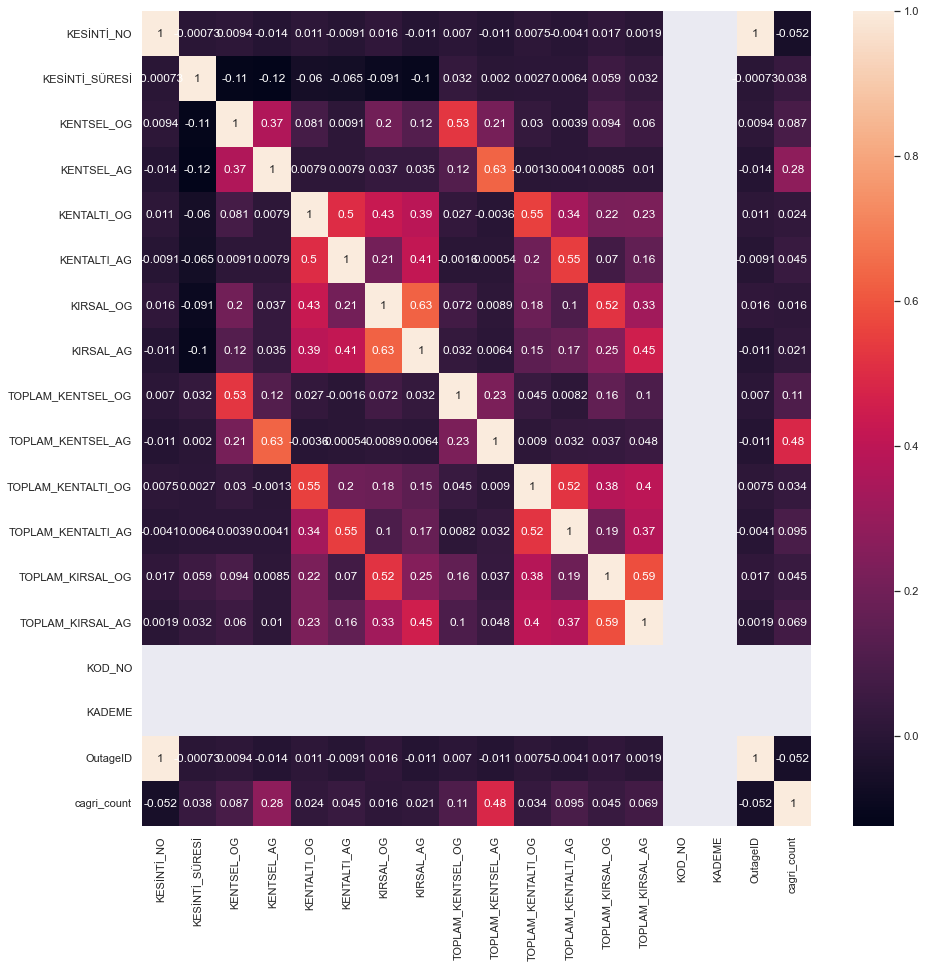

In [58]:
corr = train.corr()
a4_dims = (15, 15)
fig, ax = plt.subplots(figsize=a4_dims)
sns.heatmap(corr,annot=True)


In [59]:
train["KESİNTİ_NEDENİ"] = train["KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA"]
train.drop(columns="KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA",inplace=True)

In [60]:
train["ilce_nufus"] = train["ilce_nufus"].astype(float)

In [61]:
train["BAŞLAMA_TARİHİ_VE_ZAMANI"] = pd.to_datetime(train["BAŞLAMA_TARİHİ_VE_ZAMANI"],dayfirst=True)
train["SONA_ERME_TARİHİ_VE_ZAMANI"] = pd.to_datetime(train["SONA_ERME_TARİHİ_VE_ZAMANI"],dayfirst=True)

In [62]:
train["baslama_hour"] = train["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.hour
train["baslama_day"] = train["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.day
train["baslama_dayofweek"] = train["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.dayofweek
train["baslama_dayofyear"] = train["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.dayofyear
train["baslama_week"] = train["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.week
train["baslama_month"] = train["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.month


train["bitis_hour"] = train["SONA_ERME_TARİHİ_VE_ZAMANI"].dt.hour
train["bitis_day"] = train["SONA_ERME_TARİHİ_VE_ZAMANI"].dt.day
train["bitis_dayofweek"] = train["SONA_ERME_TARİHİ_VE_ZAMANI"].dt.dayofweek
train["bitis_dayofyear"] = train["SONA_ERME_TARİHİ_VE_ZAMANI"].dt.dayofyear
train["bitis_week"] = train["SONA_ERME_TARİHİ_VE_ZAMANI"].dt.week
train["bitis_month"] = train["SONA_ERME_TARİHİ_VE_ZAMANI"].dt.month



C:\Users\talha\AppData\Local\Temp\ipykernel_2980\1591688405.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train["baslama_week"] = train["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.week
C:\Users\talha\AppData\Local\Temp\ipykernel_2980\1591688405.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train["bitis_week"] = train["SONA_ERME_TARİHİ_VE_ZAMANI"].dt.week


In [63]:
zeros = train.set_index("BAŞLAMA_TARİHİ_VE_ZAMANI").resample("D")["cagri_count"].sum()
zeros = pd.DataFrame(zeros)
zeros[zeros["cagri_count"] == 0]

,cagri_count
BAŞLAMA_TARİHİ_VE_ZAMANI,
2022-03-24,0.0
2022-03-25,0.0
2022-03-26,0.0
2022-03-27,0.0
2022-03-28,0.0
...,...
2022-06-08,0.0
2022-06-09,0.0
2022-06-10,0.0


In [64]:
train = train[train["BAŞLAMA_TARİHİ_VE_ZAMANI"] < "2022-03-24"].reset_index(drop=True)
#train.set_index("BAŞLAMA_TARİHİ_VE_ZAMANI").resample("D")["cagri_count"].sum().plot();

In [65]:
train.drop(["KOD_NO","KADEME"],axis=1,inplace=True)
train.drop("ŞEBEKE_UNSURU_KODU",axis=1,inplace=True)
train.drop("İLÇE", axis=1, inplace=True)
#train.drop("KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA",axis=1,inplace=True)
train.drop("BİLDİRİME_GÖRE",axis=1,inplace=True)
train.drop(["BAŞLAMA_TARİHİ_VE_ZAMANI","SONA_ERME_TARİHİ_VE_ZAMANI"],axis=1,inplace=True)
train.drop("KESİNTİ_NO",axis=1, inplace=True)
train.drop("OutageID",axis=1,inplace=True)

In [75]:
target_summary_with_cat(train,"cagri_count","KESİNTİ_NEDENİ")

                                            TARGET_MEAN
KESİNTİ_NEDENİ                                         
AG Havai Branşman Arızası                      1.265487
OG Kademe Ayarı                                1.735683
AG Box / Sdk Abone Çıkış Faz Sigorta Atığı     1.819383
AG Branşman Yeraltı Kablo Arızası              1.945752
AG Box / Sdk Abone Çıkış Sigorta Atığı         1.983484
...                                                 ...
Yabani Hayvan Teması                          61.076923
OG Parafudr Patlaması                         61.558140
OG Yeraltı Kablo Arızası                      73.906137
EİH Arızası                                  120.461538
TEİAŞ Trafo Arızası                          319.631579

[63 rows x 1 columns]




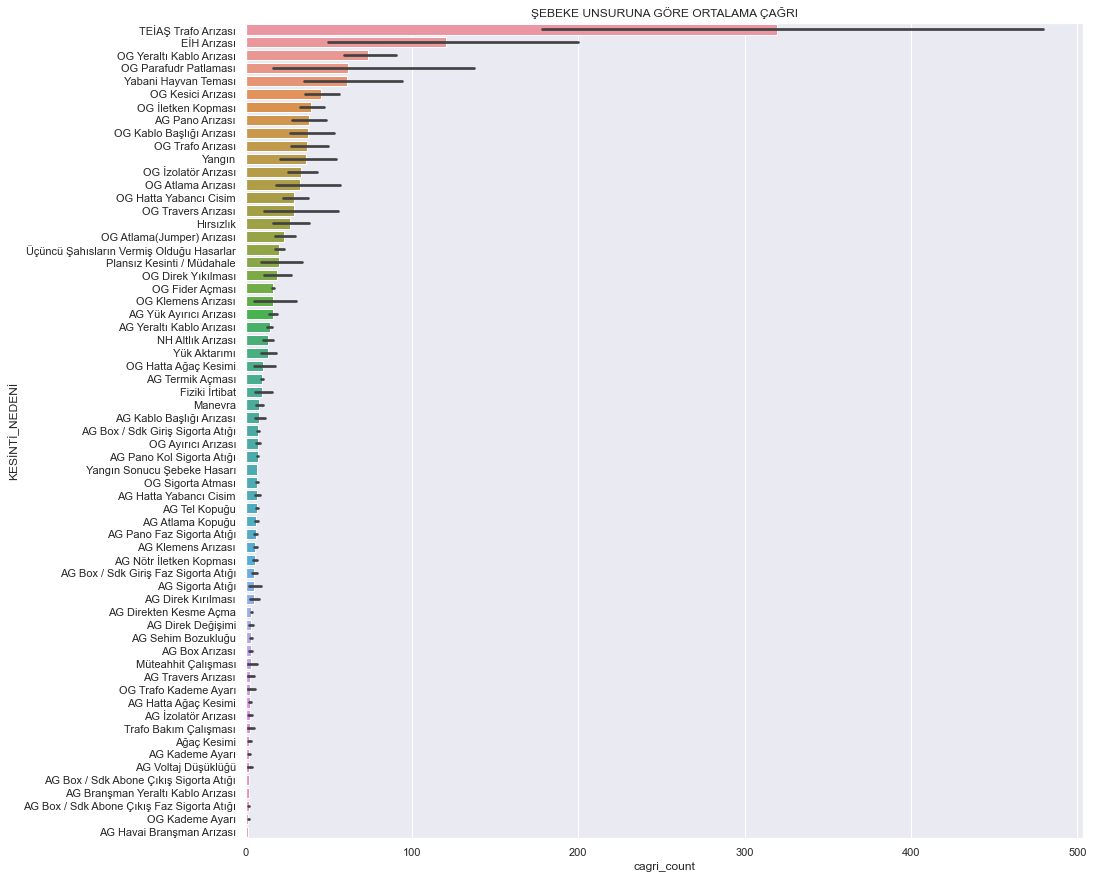

In [67]:
asc_order =train.groupby('KESİNTİ_NEDENİ')['cagri_count'].mean().sort_values(ascending=False).index.values
fig,ax = plt.subplots(figsize=(15,15))
sns.barplot(data=train,x="cagri_count",y="KESİNTİ_NEDENİ",order=asc_order,orient="horizontal")

ax.set_title("ŞEBEKE UNSURUNA GÖRE ORTALAMA ÇAĞRI");

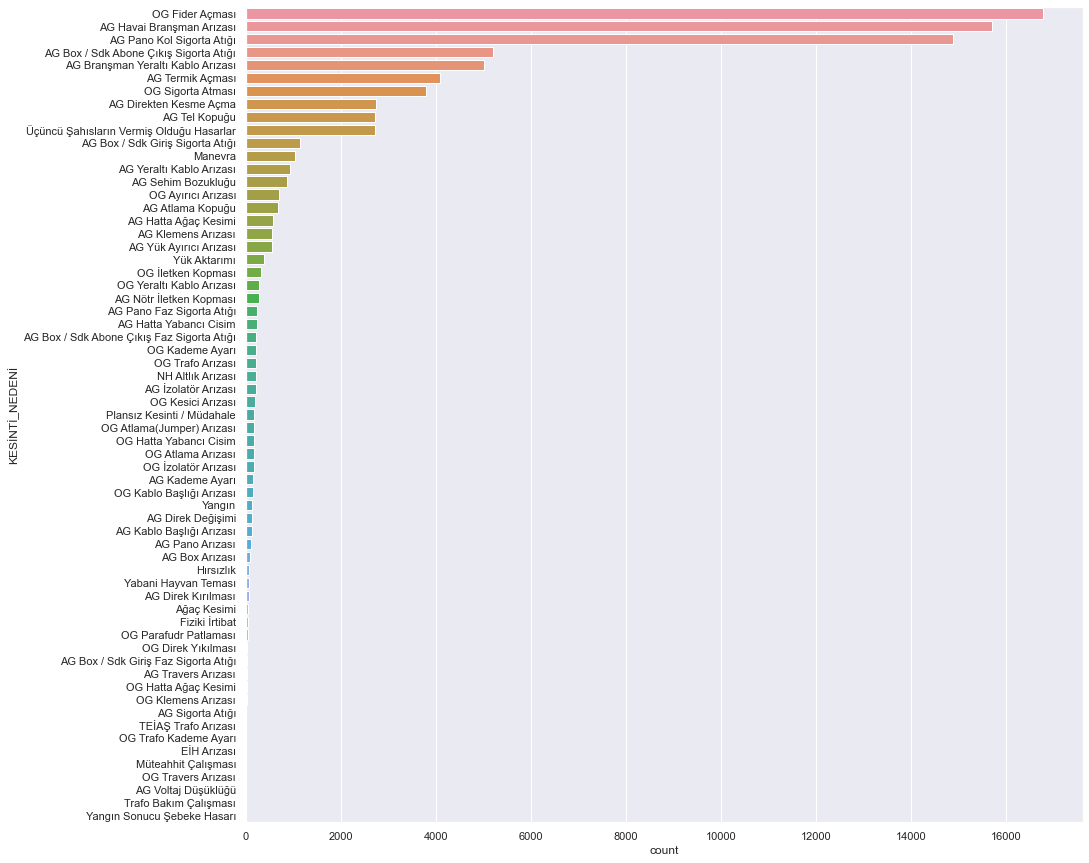

In [73]:
large_to_small = train.groupby('KESİNTİ_NEDENİ').size().sort_values().index[::-1]
fig,ax = plt.subplots(figsize=(15,15))
ax = sns.countplot(data=train, y="KESİNTİ_NEDENİ", order=large_to_small,orient="horizontal")

In [84]:
kesinti_rare = rare_analyser(train,"cagri_count", ["KESİNTİ_NEDENİ"])

KESİNTİ_NEDENİ : 63
                                            COUNT     RATIO  TARGET_MEAN
AG Atlama Kopuğu                              694  0.008045     6.370317
AG Box / Sdk Abone Çıkış Faz Sigorta Atığı    227  0.002631     1.819383
AG Box / Sdk Abone Çıkış Sigorta Atığı       5207  0.060358     1.983484
AG Box / Sdk Giriş Faz Sigorta Atığı           41  0.000475     5.390244
AG Box / Sdk Giriş Sigorta Atığı             1137  0.013180     7.497801
...                                           ...       ...          ...
Yabani Hayvan Teması                           78  0.000904    61.076923
Yangın                                        140  0.001623    36.400000
Yangın Sonucu Şebeke Hasarı                     1  0.000012     7.000000
Yük Aktarımı                                  385  0.004463    13.233766
Üçüncü Şahısların Vermiş Olduğu Hasarlar     2716  0.031483    20.418999

[63 rows x 3 columns]




In [88]:
kesinti_rare["RATIO"].sort_values()[50:]

AG Yeraltı Kablo Arızası                    0.010746
Manevra                                     0.012021
AG Box / Sdk Giriş Sigorta Atığı            0.013180
Üçüncü Şahısların Vermiş Olduğu Hasarlar    0.031483
AG Tel Kopuğu                               0.031669
AG Direkten Kesme Açma                      0.031935
OG Sigorta Atması                           0.044084
AG Termik Açması                            0.047515
AG Branşman Yeraltı Kablo Arızası           0.058121
AG Box / Sdk Abone Çıkış Sigorta Atığı      0.060358
AG Pano Kol Sigorta Atığı                   0.172486
AG Havai Branşman Arızası                   0.182072
OG Fider Açması                             0.194417
Name: RATIO, dtype: float64

In [100]:

for var in ["KESİNTİ_NEDENİ"]:
        tmp = train[var].value_counts() / len(train)
        rare_labels = tmp[tmp < 0.15].index
        train[var] = np.where(train[var].isin(rare_labels), 'Rare', train[var])

In [101]:
train["KESİNTİ_NEDENİ"].unique()

array(['OG Fider Açması', 'Rare', 'AG Pano Kol Sigorta Atığı',
       'AG Havai Branşman Arızası'], dtype=object)

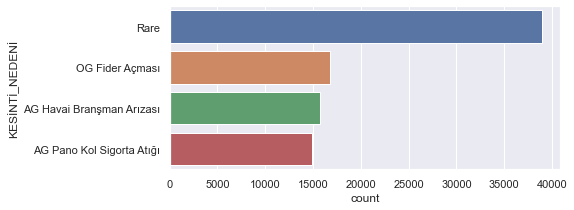

In [102]:
large_to_small = train.groupby('KESİNTİ_NEDENİ').size().sort_values().index[::-1]
fig,ax = plt.subplots(figsize=(7,3))
ax = sns.countplot(data=train, y="KESİNTİ_NEDENİ", order=large_to_small,orient="horizontal")

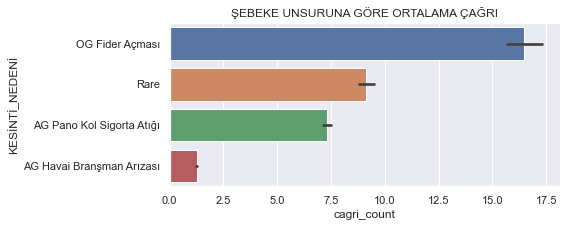

In [103]:
asc_order =train.groupby('KESİNTİ_NEDENİ')['cagri_count'].mean().sort_values(ascending=False).index.values
fig,ax = plt.subplots(figsize=(7,3))
sns.barplot(data=train,x="cagri_count",y="KESİNTİ_NEDENİ",order=asc_order,orient="horizontal")

ax.set_title("ŞEBEKE UNSURUNA GÖRE ORTALAMA ÇAĞRI");

In [76]:
target_summary_with_cat(train,"cagri_count","ŞEBEKE_UNSURU")

                           TARGET_MEAN
ŞEBEKE_UNSURU                         
Abone Tesisi                  1.579841
AG Fideri                     6.829145
Saha Dağıtım Kutusu (SDK)     9.072140
Dağıtım Transformatörü       10.050094
KÖK                          10.271268
OG Fideri                    15.596047
DM                           18.959956
TM Fideri                    54.970219




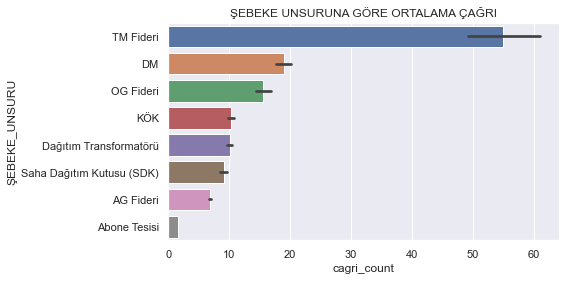

In [107]:
asc_order =train.groupby('ŞEBEKE_UNSURU')['cagri_count'].mean().sort_values(ascending=False).index.values
fig,ax = plt.subplots(figsize=(7,4))
sns.barplot(data=train,x="cagri_count",y="ŞEBEKE_UNSURU",order=asc_order, orient="horizontal")
ax.set_title("ŞEBEKE UNSURUNA GÖRE ORTALAMA ÇAĞRI");

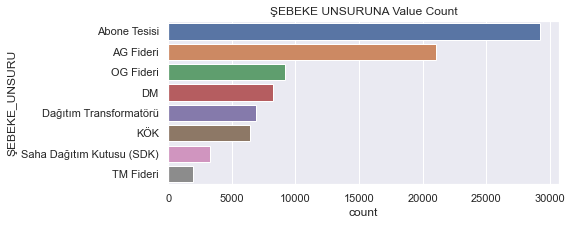

In [108]:
large_to_small = train.groupby('ŞEBEKE_UNSURU').size().sort_values().index[::-1]
fig,ax = plt.subplots(figsize=(7,3))
ax = sns.countplot(data=train, y="ŞEBEKE_UNSURU", order=large_to_small,orient="horizontal")
ax.set_title("ŞEBEKE UNSURUNA Value Count");

In [77]:
target_summary_with_cat(train,"cagri_count","KAYNAĞA_GÖRE")

              TARGET_MEAN
KAYNAĞA_GÖRE             
Dağıtım-AG       4.781445
Dağıtım-OG      17.818462
İletim          40.807453




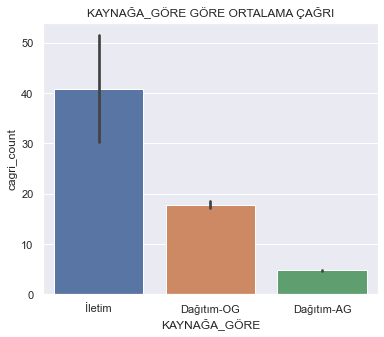

In [109]:
asc_order =train.groupby('KAYNAĞA_GÖRE')['cagri_count'].mean().sort_values(ascending=False).index.values
fig,ax = plt.subplots(figsize=(6,5))
sns.barplot(data=train,x="KAYNAĞA_GÖRE",y="cagri_count",order=asc_order);
ax.set_title("KAYNAĞA_GÖRE GÖRE ORTALAMA ÇAĞRI");

In [78]:
target_summary_with_cat(train,"cagri_count","SÜREYE_GÖRE")

             TARGET_MEAN
SÜREYE_GÖRE             
Kısa            0.037369
Uzun            9.076632




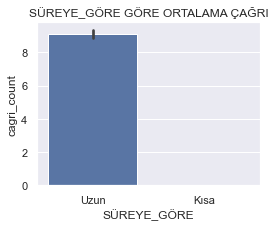

In [110]:
asc_order =train.groupby('SÜREYE_GÖRE')['cagri_count'].mean().sort_values(ascending=False).index.values
fig,ax = plt.subplots(figsize=(4,3))
sns.barplot(data=train,x="SÜREYE_GÖRE",y="cagri_count",order=asc_order);
ax.set_title("SÜREYE_GÖRE GÖRE ORTALAMA ÇAĞRI");

In [79]:
target_summary_with_cat(train,"cagri_count","SEBEBE_GÖRE")

                    TARGET_MEAN
SEBEBE_GÖRE                    
Şebeke işletmecisi     8.348295
Dışsal                30.003028
Güvenlik              52.193182




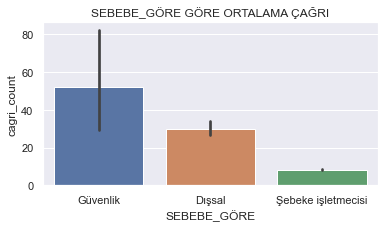

In [111]:
asc_order =train.groupby('SEBEBE_GÖRE')['cagri_count'].mean().sort_values(ascending=False).index.values
fig,ax = plt.subplots(figsize=(6,3))
sns.barplot(data=train,x="SEBEBE_GÖRE",y="cagri_count",order=asc_order);
ax.set_title("SEBEBE_GÖRE GÖRE ORTALAMA ÇAĞRI");

In [113]:
num_cols, cat_cols, cat_but_car = grab_col_names(train)

Observations: 86268
Variables: 33
cat_cols: 8
num_cols: 25
cat_but_car: 0
num_but_cat: 2


In [116]:
rare_analyser(train,"cagri_count",cat_cols)

İL : 2
        COUNT     RATIO  TARGET_MEAN
izmir   59277  0.687126     9.832110
manisa  26991  0.312874     6.557112


ŞEBEKE_UNSURU : 8
                           COUNT     RATIO  TARGET_MEAN
AG Fideri                  21053  0.244042     6.829145
Abone Tesisi               29258  0.339152     1.579841
DM                          8216  0.095238    18.959956
Dağıtım Transformatörü      6887  0.079833    10.050094
KÖK                         6418  0.074396    10.271268
OG Fideri                   9209  0.106749    15.596047
Saha Dağıtım Kutusu (SDK)   3313  0.038404     9.072140
TM Fideri                   1914  0.022187    54.970219


KAYNAĞA_GÖRE : 3
            COUNT     RATIO  TARGET_MEAN
Dağıtım-AG  60479  0.701059     4.781445
Dağıtım-OG  25306  0.293342    17.818462
İletim        483  0.005599    40.807453


SÜREYE_GÖRE : 2
      COUNT     RATIO  TARGET_MEAN
Kısa   2569  0.029779     0.037369
Uzun  83699  0.970221     9.076632


SEBEBE_GÖRE : 3
                    COUNT     RATI

In [30]:
train_dum = pd.get_dummies(train)

In [31]:
corr = train_dum.corr()
data=corr["cagri_count"].sort_values(ascending=False)
data =pd.DataFrame(data)
data = data.reset_index()
data = data[data["index"]!="cagri_count"]

In [32]:
for i in data["index"]:
    if "KESİNTİ_NEDENİ" in i:
        ind = data[data["index"] == i].index[0]
        data.drop(index=ind,axis=0,inplace=True)

In [33]:
kesinti = []
for i in train_dum.columns:
    if "KESİNTİ_NEDENİ" in i:
        kesinti.append(i)
        print(i)

KESİNTİ_NEDENİ_AG Atlama Kopuğu
KESİNTİ_NEDENİ_AG Box / Sdk Abone Çıkış Faz Sigorta Atığı
KESİNTİ_NEDENİ_AG Box / Sdk Abone Çıkış Sigorta Atığı
KESİNTİ_NEDENİ_AG Box / Sdk Giriş Faz Sigorta Atığı
KESİNTİ_NEDENİ_AG Box / Sdk Giriş Sigorta Atığı
KESİNTİ_NEDENİ_AG Box Arızası
KESİNTİ_NEDENİ_AG Branşman Yeraltı Kablo Arızası
KESİNTİ_NEDENİ_AG Direk Değişimi
KESİNTİ_NEDENİ_AG Direk Kırılması
KESİNTİ_NEDENİ_AG Direkten Kesme Açma
KESİNTİ_NEDENİ_AG Hatta Ağaç Kesimi
KESİNTİ_NEDENİ_AG Hatta Yabancı Cisim
KESİNTİ_NEDENİ_AG Havai Branşman Arızası
KESİNTİ_NEDENİ_AG Kablo Başlığı Arızası
KESİNTİ_NEDENİ_AG Kademe Ayarı
KESİNTİ_NEDENİ_AG Klemens Arızası
KESİNTİ_NEDENİ_AG Nötr İletken Kopması
KESİNTİ_NEDENİ_AG Pano Arızası
KESİNTİ_NEDENİ_AG Pano Faz Sigorta Atığı
KESİNTİ_NEDENİ_AG Pano Kol Sigorta Atığı
KESİNTİ_NEDENİ_AG Sehim Bozukluğu
KESİNTİ_NEDENİ_AG Sigorta Atığı
KESİNTİ_NEDENİ_AG Tel Kopuğu
KESİNTİ_NEDENİ_AG Termik Açması
KESİNTİ_NEDENİ_AG Travers Arızası
KESİNTİ_NEDENİ_AG Voltaj Düşüklüğü
KESİ

In [34]:
kesintidf = train_dum[kesinti]
kesintidf["cagri_count"] = train_dum["cagri_count"]
corr = kesintidf.corr()
datak=corr["cagri_count"].sort_values(ascending=False)
datak =pd.DataFrame(datak)
datak = datak.reset_index()
datak = datak[datak["index"]!="cagri_count"]

C:\Users\talha\AppData\Local\Temp\ipykernel_2980\3427025581.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kesintidf["cagri_count"] = train_dum["cagri_count"]


<AxesSubplot:xlabel='cagri_count', ylabel='index'>

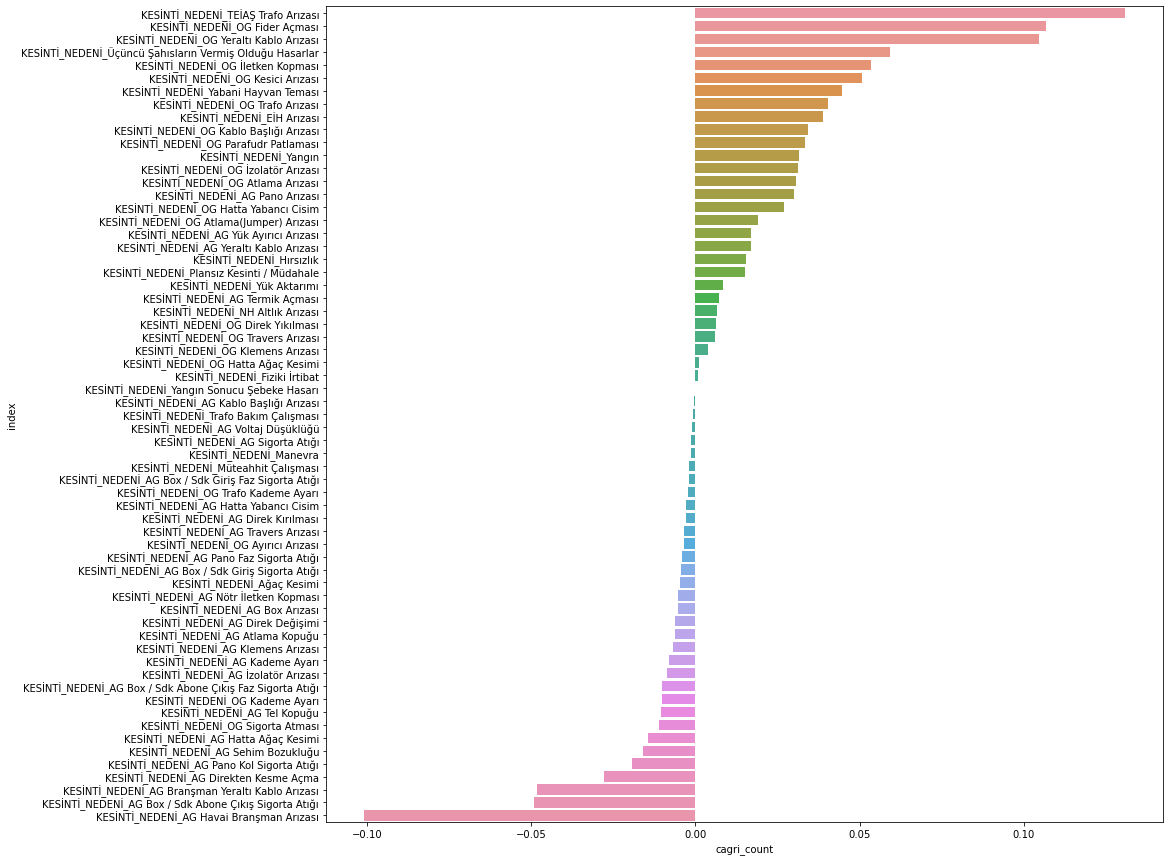

In [35]:
fig,ax=plt.subplots(figsize=(15,15))
sns.barplot(data=datak, x=datak["cagri_count"],y=datak["index"] , orient="horizontal")

<AxesSubplot:xlabel='cagri_count', ylabel='index'>

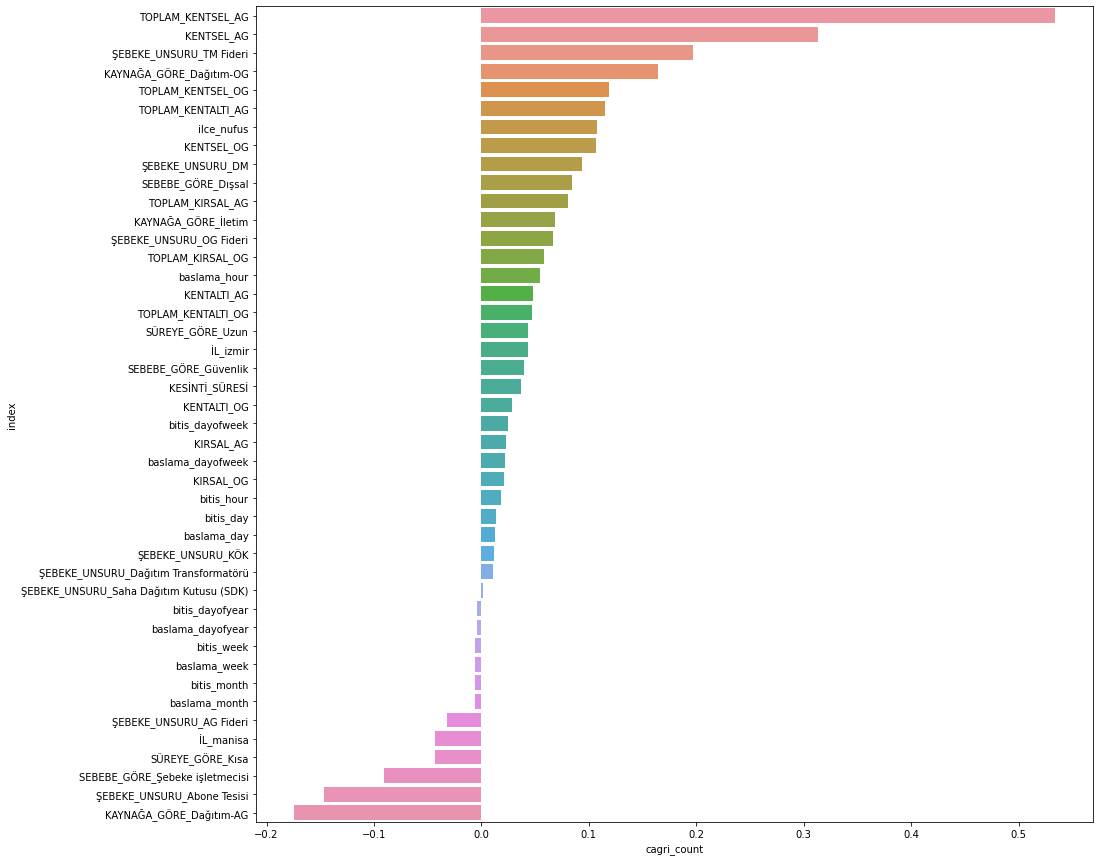

In [36]:
fig,ax=plt.subplots(figsize=(15,15))
sns.barplot(data=data, x=data["cagri_count"],y=data["index"] , orient="horizontal")

# Modelleme

In [37]:
train_dum = pd.get_dummies(train,drop_first=True)

In [38]:
y = train_dum["cagri_count"]
X = train_dum.drop("cagri_count",axis=1)

In [39]:
#X = RobustScaler().fit_transform(X)
#X = pd.DataFrame(X)

In [40]:
X.head()

,KESİNTİ_SÜRESİ,KENTSEL_OG,KENTSEL_AG,KENTALTI_OG,KENTALTI_AG,KIRSAL_OG,KIRSAL_AG,TOPLAM_KENTSEL_OG,TOPLAM_KENTSEL_AG,TOPLAM_KENTALTI_OG,...,KESİNTİ_NEDENİ_OG İletken Kopması,KESİNTİ_NEDENİ_OG İzolatör Arızası,KESİNTİ_NEDENİ_Plansız Kesinti / Müdahale,KESİNTİ_NEDENİ_TEİAŞ Trafo Arızası,KESİNTİ_NEDENİ_Trafo Bakım Çalışması,KESİNTİ_NEDENİ_Yabani Hayvan Teması,KESİNTİ_NEDENİ_Yangın,KESİNTİ_NEDENİ_Yangın Sonucu Şebeke Hasarı,KESİNTİ_NEDENİ_Yük Aktarımı,KESİNTİ_NEDENİ_Üçüncü Şahısların Vermiş Olduğu Hasarlar
0,5.084444,3,1613,0,0,0,0,15.253333,8201.208888,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1.729167,3,1613,0,0,0,0,5.187500,2789.145832,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1.466111,14,15,0,0,0,0,20.525556,21.991667,0.0,...,0,0,0,0,0,0,0,0,0,0
3,1.099444,8,2752,0,0,0,0,8.795556,3025.671110,0.0,...,0,0,0,0,0,0,0,0,0,1
4,2.116389,1,40,0,0,0,0,2.116389,84.655556,0.0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
def base_reg_models(X, y, scoring="neg_mean_squared_error"):
    print("Base Regression Models....")
    regressors = [('LR', LinearRegression()),
                  ("DT", DecisionTreeRegressor()),
                  #('GB', GradientBoostingRegressor(verbose=False)),
                  ('ADA', AdaBoostRegressor()),
                  ('XGB', XGBRegressor()),
                  ('LGBM', LGBMRegressor()),
                  ('CB', CatBoostRegressor(verbose=False))
                  ]

    for name, regressor in regressors:

        cv_result = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=5, scoring=scoring)))

        print(f"{scoring}: {round(cv_result, 4)} ({name}) ")


base_reg_models(X, y)


#Base Regression Models....
#neg_mean_squared_error: 131.4927 (LR) 
#neg_mean_squared_error: 38.4812 (DT) 
#neg_mean_squared_error: 25.5298 (RF) 
#neg_mean_squared_error: 26.938 (GB) 
#neg_mean_squared_error: 117.4336 (ADA) 
#neg_mean_squared_error: 27.8393 (XGB) 
#neg_mean_squared_error: 25.5299 (LGBM) 
#neg_mean_squared_error: 25.7145 (CB) 

# ilcesiz robust
#
#neg_mean_squared_error: 74.2547 (LR) 
#neg_mean_squared_error: 38.8515 (DT) 
#neg_mean_squared_error: 25.8657 (RF) 
#neg_mean_squared_error: 26.9094 (GB) 
#neg_mean_squared_error: 90.4214 (ADA) 
#neg_mean_squared_error: 27.2804 (XGB) 
#neg_mean_squared_error: 25.5323 (LGBM) 
#neg_mean_squared_error: 25.4069 (CB) 




Base Regression Models....
neg_mean_squared_error: 30.6573 (LR) 
neg_mean_squared_error: 34.1912 (DT) 
neg_mean_squared_error: 115.4338 (ADA) 
neg_mean_squared_error: 25.2526 (XGB) 
neg_mean_squared_error: 24.2816 (LGBM) 
neg_mean_squared_error: 23.7041 (CB) 


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=22)

xgb = XGBRegressor()
xgb.fit(X_train,y_train)

y_pred = xgb.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))

# nisan öncesi 26.02156654
# ilcesiz 26.209088711991203
# ilcesiz robust 26.13611120821512
# ilcesiz nisanlı 22.510970156638695

25.555271342588984


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=22)
lgbm = LGBMRegressor()
lgbm.fit(X_train,y_train)

y_pred = lgbm.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))
# base nisan öncesi 25.742758536057423
# ilcesiz 24.56702527927839
# ilcesiz robust 24.352886090166667
# ilcesiz nisanlı 21.67244299890845
# ilcesiz nisansız kesinit_nedenli 24.48178541387783

24.48178541387783


In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=22)
catboost = CatBoostRegressor()
catboost.fit(X_train,y_train,verbose=False)

y_pred = catboost.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))

# base nisan öncesi 23.804272135207512
# ilcesiz 24.28086379730011
# ilcesiz robust 24.280825244392016
# ilcesiz nisanlı 20.986184475963626

24.155983706780862


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=22)
randomforest = RandomForestRegressor()
randomforest.fit(X_train,y_train)

y_pred = randomforest.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))

22.206293728639835


In [49]:
def plot_importance(model, features, X, save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 15))
    sns.set(font_scale=1)
    num = len(X)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


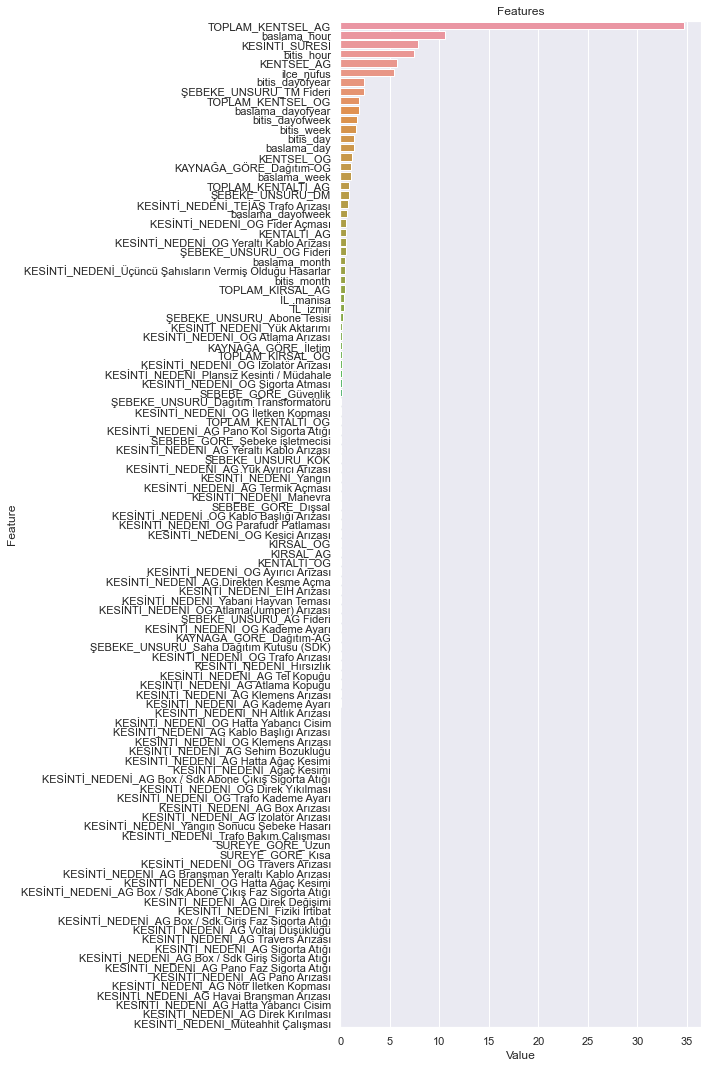

In [50]:
plot_importance(catboost,X_train,X_train)

In [51]:
#best lgbm
joblib.dump(lgbm,"kesinti_lgbm_model.pkl")

['kesinti_lgbm_model.pkl']